# Running Molecular Dynamics Simulations in OpenMM

## Overview
**Molecular Dynamics Simulation**: simulation of molecules through time via calculations of forces on atoms and their positions based on those forces. The output is a trajectory.

## Steps for running a simulation
1. **Initialization** -- setting up imports, variables, and other system parameters to prepare for the simulation
2. **Minimization** -- calculating the energies of moving molecules slightly to obtain a local "minimum" in energy and eliminate “bad” interatomic contacts
3. **Equilibration** -- a brief MD simulation that prepares our system to our target temperature and desired equilibrium values
4. **Production** -- run the equilibration
5. **Analysis** -- after you have collected your data from the production run, you must analyze the trajectory to draw conclusions

## Our First Simulations
We will now use [OpenMM](https://openmm.org/documentation) to do a molecular dynamics simulation of the ethane and butane molecules we prepared. It’s important to note at this point that molecular dynamics simulations can be performed using a number of softwares. However, we will be running a simulation with a program called OpenMM. OpenMM has the advantage of being scriptable with Python.

---

### Initialization
Once you have OpenMM, we can use it to simulate our molecules. Start in your notebook with imports. Here are the python libraries you will need to run simulations with OpenMM.

In [1]:
import openmm as mm
from openmm import app, unit

First, we need to read in our structure and our force field. We have to tell the simulation our initial coordinates and the force field we will use. To do this, we use the PDB file we have and the force field file we prepared.

In [2]:
pdb = app.PDBFile('data/ethane.pdb')
forcefield = app.ForceField('data/ethane.gaff2.xml')

#### QUESTION
What are we doing with these two commands above?
*(Hint: let's check out some [documentation](http://docs.openmm.org/latest/userguide/application/02_running_sims.html))*

#### RESPONSE
The first one "loads a PDB file that defines a biomolecular system" from our storage. The second one creates an object called Forcefield out of it.

#### QUESTION
What lies in the contents of the XML file being read in `forcefield`?

#### RESPONSE
There are Atom types description, that are grouped by the way a forcefield would treat them. There are Residue Templates, that are a bank of Templates that can be associated with the Atome types grouping we have. Then there are Forces definition. Several of them can be included, and they can, or can not have an influence over certain atoms groups.

Next, we set up the system for our MD simulation. With the following command, we use the `pdb` variable to create a system. The other arguments to the function say that we are not using a cut-off and that we want to constrain bonds with hydrogens (this allows us to use a larger timestep).

In [3]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

Our simulation will be in vacuum at a temperature of 298.15 K. The Langevin integrator is what is called a stochastic integrator. This means that it mimics jostling of air or solvent through random forces. We are using a 5.0 picosecond coupling constant, which is something which controls how often the integrator adds jostling motions.

In [4]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

#### QUESTION
What is the `integrator` applying to our simulation?

#### RESPONSE
We use a Langevin Integrator, which is a kind of Monte Carlo simulation.

Finally, we initialize the simulation by adding all of the pieces we have prepared:

In [5]:
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology,system, integrator, platform) # ENTER THE THREE PIECES OF OUR SIMULATION HERE (hmm... I wonder where I can find this)
simulation.context.setPositions(pdb.positions)

---

### Minimization
Now, we start calculating energies. First we do an energy minimization. We start in this code block by printing the energy before minimization, doing 100 steps of an energy minimization, then printing the new energy. You should see that the energy decreases:

In [6]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 4.4678182710651875 kJ/mol
Potential energy after minimization is 4.389967724953273 kJ/mol


You can’t see it from this code, but the atom positions have changed slightly to cause this change in energy.

#### QUESTION
What is an energy minimization? Why do we want to perform a local energy minimization at the start of our simulation?

#### RESPONSE
It means rearranging the atoms in a formation where the inter atomic forces are closer to 0. We minimize it because the PDB file content could lead to very large forces. 

---

### Equilibration
Next, we run an equilibration. The purpose of this equilibration is to get our system to our target temperature and to get the system equilibrated and ready for our production run.

In [7]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,19.70229956063671,187.82349865755222
200,26.546051762990714,179.71483358450956
300,19.296457770414918,250.27143345897503
400,22.941525355734797,367.9323714962911
500,25.05253681421561,359.18479447961755
600,24.68231262875975,430.32664689725993
700,16.2128225402793,263.48880473532466
800,14.233138641397314,382.10259611400244
900,11.133463604307376,341.1080359433256
1000,16.7621092738318,290.47586594132986
1100,24.110407925392522,370.03089818938963
1200,21.83363724606634,502.87381634257866
1300,10.947036514818858,551.6139558189187
1400,27.612499789717297,340.34375641616043
1500,20.34939903638481,183.092349744168
1600,16.359949241852558,123.17858397452734
1700,13.311127745871739,236.90708550485658
1800,16.454408258616446,276.81130703007034
1900,16.102604332847505,367.40521815975507
2000,27.397159425354417,340.37667285804673
2100,23.169153176377982,305.2738476374737
2200,27.21790043786935,338.3331984447078
2300,28.

The first command in this section sets up what information OpenMM will report to us as the simulation runs. We are asking for the potential energy, and temperature every 100 timesteps. By putting `stdout` as the first argument, we are telling the program to just print the information. Note that `stdout` comes from the built in Python module `sys`. If we wanted the information in a file instead, you would put the file name.

The second command sets the initial velocities of the system to a temperature equivalent of 150 K. Then, we integrate for 2,500 steps to allow the system to equilibrate.

---

### Production
This next block of code is a longer block of simulation called the ‘production run’. We’re also added a timer to this code so we can see how long it took our simulation to run.

In [8]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(10000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,16.922909171780603,247.28605946389357,--
500000,999.9999999901769,19.876756975925304,208.20209816236436,2.18e+04
750000,1499.9999999783536,33.077821737887085,320.0236010855224,2.23e+04
1000000,1999.9999999665301,14.6474491063676,215.27567633875603,2.27e+04
1250000,2499.9999999547067,20.626207280037058,557.7163350790079,2.27e+04
1500000,2999.9999999428833,17.788576872621295,433.8887846722531,2.28e+04
1750000,3499.99999993106,21.09221997197457,370.7324371906108,2.28e+04
2000000,3999.9999999192364,13.443476231422432,321.24817660659505,2.29e+04
2250000,4499.9999999992715,15.166644683736335,479.15424806124963,2.3e+04
2500000,5000.000000101135,22.027650851580297,228.01301118877527,2.3e+04
2750000,5500.000000202998,14.294593715960824,263.00303562062544,2.31e+04
3000000,6000.000000304862,11.596422067445767,518.2705143008122,2.3e+04
3250000,6500.000000406725,12.9864

After executing this cell in your notebook, you should see an output which gives you the step number, simulation time, potential energy, temperature, and “speed” for steps in the simulation. The spacing of theses is set in the `simulation.reporters` step where we indicated we wanted information printed every 250,000 timesteps.

The “speed” is reported in “ns/day” or “nanoseconds/day”. This is a commonly used unit to report how quickly simulations run. It tells you how much simulation time in nanoseconds would pass for 24 hours of computation time. For example, if a simulation is running at 2 ns/day, enough timesteps would be calculated in one day to make 2 nanoseconds of simulation time. If we were using our 2 fs timestep, this would mean that the computer calculated 1,000,000 timesteps over 24 hours.

---

## Your Turn
Make a copy of the code you wrote to run your ethane simulation and modify it to:
1. Read in the files `butane.gaff2.xml` and `butane.pdb`
2. Carry out a 10 ps MD simulation to bring the butane molecule to an equilibrium temperature of 298 K in which output is printed every 0.5 ps (Leave the minimization portion beforehand unchanged.)
3. Carry out a 40 ns MD simulation at 298 K in which output is printed every 1 ns and structures are (still) saved every 0.2 ps into a file called `butane_sim.dcd`.

---

In [21]:
pdb = app.PDBFile('data/butane.pdb')
forcefield = app.ForceField('data/butane.gaff2.xml')

system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

In [22]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

In [23]:
platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology,system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [24]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.797528692127868 kJ/mol
Potential energy after minimization is 5.295784483017454 kJ/mol


In [25]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,27.703924165856478,239.67463755208897
200,48.96151114063592,384.10346630885135
300,41.24061697512667,300.29926117321014
400,33.49761169108619,312.3796102122284
500,22.536127866406574,318.1204327970148
600,33.680187740126286,284.46435225302156
700,28.84793976106767,277.8924958266097
800,31.528918122226536,290.3836081608626
900,53.78177655494951,221.46425428713084
1000,47.46076630338781,275.0510820563822
1100,23.174077782555,332.4034800233695
1200,30.68394200490951,161.93676133829265
1300,35.92026245108857,283.3183347762737
1400,41.35886655259885,358.1129153055527
1500,49.58703851679742,280.31768881927496
1600,35.50169202360611,202.88051982686738
1700,48.66654631178578,187.4928351329359
1800,34.01267820202072,309.84868383877784
1900,38.50679488638198,284.9053183834088
2000,35.821036423041825,320.36487456336954
2100,42.202043275220895,419.25982755018964
2200,36.48459568919362,186.98312598009315
2300,39.07084386339

In [32]:
#12
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(5000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
82750,165.50000000006213,28.914106892071405,202.70231770038978,--
83000,166.00000000006452,55.29909247559044,376.60081712889325,4.8e+03
83250,166.5000000000669,37.88925580171983,260.6457097602592,5.76e+03
83500,167.0000000000693,43.789596382219806,477.4627226076158,5.89e+03
83750,167.50000000007168,38.407540732539296,586.328411610105,5.95e+03
84000,168.00000000007407,43.93434063842793,419.3153684339264,6.17e+03
84250,168.50000000007645,58.30752254950739,209.4153519636634,6.32e+03
84500,169.00000000007884,47.177193563786766,345.09500847137036,6.3e+03
84750,169.50000000008123,46.38295727324497,245.387158191094,6.29e+03
85000,170.00000000008362,65.1392408149809,312.91395053419353,6.38e+03
85250,170.500000000086,56.121592011260105,350.7770384332455,6.45e+03
85500,171.0000000000884,64.21324185435228,228.1564787908616,6.42e+03
85750,171.50000000009078,46.41527600511638,227.01851810427002

In [32]:
# 13 (I did not do this one)
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(5000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
82750,165.50000000006213,28.914106892071405,202.70231770038978,--
83000,166.00000000006452,55.29909247559044,376.60081712889325,4.8e+03
83250,166.5000000000669,37.88925580171983,260.6457097602592,5.76e+03
83500,167.0000000000693,43.789596382219806,477.4627226076158,5.89e+03
83750,167.50000000007168,38.407540732539296,586.328411610105,5.95e+03
84000,168.00000000007407,43.93434063842793,419.3153684339264,6.17e+03
84250,168.50000000007645,58.30752254950739,209.4153519636634,6.32e+03
84500,169.00000000007884,47.177193563786766,345.09500847137036,6.3e+03
84750,169.50000000008123,46.38295727324497,245.387158191094,6.29e+03
85000,170.00000000008362,65.1392408149809,312.91395053419353,6.38e+03
85250,170.500000000086,56.121592011260105,350.7770384332455,6.45e+03
85500,171.0000000000884,64.21324185435228,228.1564787908616,6.42e+03
85750,171.50000000009078,46.41527600511638,227.01851810427002

## Analysis
Now that we’ve performed our computer experiment, it is time to analyze the data we have collected. The main type of data you have collected through this simulation is information on atom positions, or the system trajectory.

As part of our production simulation, we set up a reporter to record atomic positions. The code below shows that code from your previous script, **you do not need to execute it.**

In [ ]:
simulation.reporters.append(app.DCDReporter('ethane_sim.dcd', 100))

This reporter saved the atomic positions for us every 100 timesteps in a file called `ethane_sim.dcd`. The DCD file format is a binary file (instead of being a text file), so you cannot open it and look at it. However, we will be using certain libraries to analyze and view the file’s contents. If you’ve run your simulation, you should have the file `ethane_sim.dcd` in the same folder as your Jupyter notebook.

First, we will need to make sure we have a few more Python libraries installed which can help us with analysis. We will use a library called **nglview** to visualize the trajectory, and a library called **MDTraj** to analyze the trajectory. Before opening a new notebook for analysis, you may need to install **nglview** and **MDTraj**.

Type the following in your *terminal* to install **nglview** and **MDTraj**:

In [ ]:
$ conda install -c conda-forge mdtraj nglview

In [1]:
import mdtraj as md

traj = md.load('ethane_sim.dcd', top='data/ethane.pdb')

The command above reads all of the atomic positions from `ethane_sim.dcd` and keeps track of atom connectivity (topology) which was given in the PDB file. Next, visualize the trajectory using nglview. Nglview has a special function `show_mdtraj` that we can use with our trajectory because it was in a specific format from the MDTraj library.

In [3]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=99999)

This should show you something that looks sort of like a movie of your ethane molecule. These are the atomic positions calculated by OpenMM during the molecular dynamics run. We can now analyze the positions to find out some things about our molecule.

We will use another OpenMM command to pull out our bonds and atoms for analysis

In [4]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,ETH,0,
1,2,H11,H,1,ETH,0,
2,3,H12,H,1,ETH,0,
3,4,H13,H,1,ETH,0,
4,5,C2,C,1,ETH,0,
5,6,H21,H,1,ETH,0,
6,7,H22,H,1,ETH,0,
7,8,H23,H,1,ETH,0,


#### QUESTION
Describe the table that `atoms` produced.

#### RESPONSE
There are 8 rows and 7 columsn We first get the serial number, which looks like a key for a databse. Then the name of the atome, the corresponding element, the resSeq and resName that are the Residue Sequence and name. Then we have the chainID and the SegmentID.

### Analyzing the C-C bond length
Let’s look at what C-C bond lengths our ethane molecule had during the simulation. Before we can measure the bond lengths, we have to decide which atoms from our molecule define the bond angle. You should see a table output from running `atoms`.

We have to pick the atom indices for the C-C bond. An atom’s index is the left-most value in the table above. For our torsion, we’ll measure `C1-C2` the indices for these are `0` and `4`. We use the function `compute_distances` in the MDTraj library to measure the distance between these atoms.

In [5]:
bond_indices = [0, 4] # atoms to define the bond length
bond_length = md.compute_distances(traj, [bond_indices])

We now have the measurement for this torsion angle in radians for each recorded timestep of the trajectory saved in the array `bond_length`. One way we can examine this data is by plotting it as a histogram using the Python library `matplotlib`.

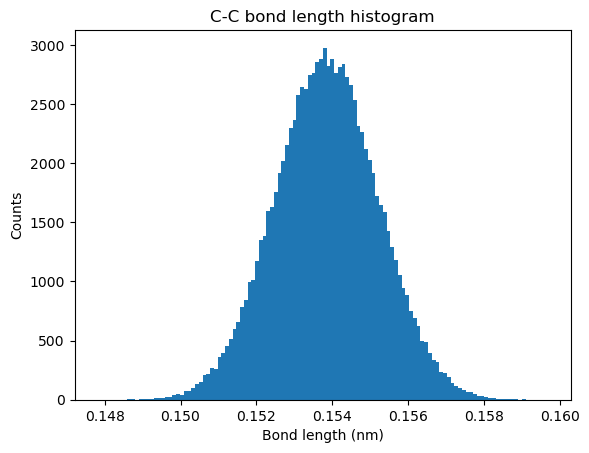

In [6]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(bond_length, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

## Your Turn
A torsion is made up of four atoms which are bonded to each other. Analyze the torsion angle associated with the atoms `H11-C1-C2-H21` for your trajectory. Instead of using the function `compute_distance`, use `compute_dihedrals`. Create a histogram plot of the torsion angles.

First, we need to pick the atom indices of our torsion angle and use the `compute_dihedrals` function to calculate the dihedrals.

In [8]:
phi_indices = [1,0,4,6] # add atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])# use the compute_dihedrals function

print(phi)

[[ 0.7489513]
 [ 1.1254169]
 [ 1.1147032]
 ...
 [ 1.9787287]
 [-0.5354655]
 [-1.4299799]]


We now have the measurement for this torsion angle in radians for each recorded timestep of the trajectory.

Next, we can examine this data by plotting it as a histogram using the Python library `matplotlib`.

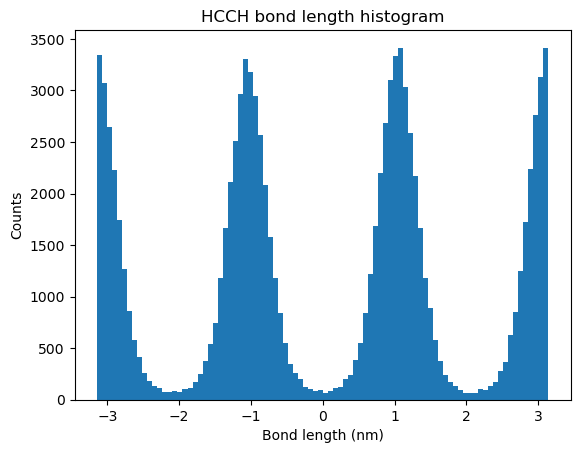

In [10]:
import matplotlib.pyplot as plt

# create a histogram with 90 bins
bondcounts, binedges, otherstuff = plt.hist(phi, bins=90)
plt.title('HCCH bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

Credit for this exercise goes to [MolSSI](https://education.molssi.org/mm-tools/02-md-alkanes/index.html).